# **Ragas Evaluation**

### **Loading Lecture Materials**

In [1]:
from langchain_community.document_loaders.directory import DirectoryLoader

loader = DirectoryLoader("documents")
docs = loader.load()

This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores.faiss import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings


text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(docs)
embeddings = HuggingFaceEmbeddings()
vectorstore = FAISS.from_documents(documents=chunks, embedding=embeddings)
retriever = vectorstore.as_retriever()

## **Test Dataset Generation**

In [79]:
def generate_prompt(question):

    template = """For each question and context, create an answer only using the context. If the context does not contain the answer, say you are unable to answer the question using the context. Do not make up an answer.

    answer: answer to the question using the context.

    question: {question}

    context: {context}"""

    docs = vectorstore.similarity_search(question)
    context = "\n\n".join([doc.page_content for doc in docs])

    return template.format(question=question, context=context)

In [4]:
generate_prompt("Who is Neil Armstrong?")

'For each question and context, create an answer only using the context. If the context does not contain the answer, say you are unable to answer the question using the context. Do not make up an answer.\n\n    answer: answer to the question using the context.\n\n    question: Who is Neil Armstrong?\n\n    context: The bag of words representation\n\nγ(\n\n)=c\n\nF20/F21 AA Applied Text Analytics\n\n6\n\nThe bag of words representation\n\nI love this movie! It\'s sweet, but with satirical humor. The dialogue is great and the adventure scenes are fun…  It manages to be whimsical and romantic while laughing at the conventions of the fairy tale genre. I would recommend it to just about anyone. I\'ve seen it several times, and I\'m always happy to see it again whenever I have a friend who hasn\'t seen it yet.\n\nγ(\n\n)=c\n\nF20/F21 AA Applied Text Analytics\n\n7\n\nThe bag of words representation: \x0busing a subset of words\n\nx love xxxxxxxxxxxxxxxx sweet xxxxxxx satirical xxxxxxxxxx xxx

## **Evaluation**

### **Setup**

In [111]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio", temperature=0.1)
llm_temp07 = ChatOpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio", temperature=0.7)


In [112]:
from langchain_core.prompts import PromptTemplate

# template = """Answer the question based only on the following context:
# {context}

# Question: {question}
# """
template = """Answer the question using the context.

question: {question}
context: {context}"""

prompt = PromptTemplate(
    template=template,
    input_variables=["context","question"]
  )

In [113]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs,  "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain_temp07 = (
    {"context": retriever | format_docs,  "question": RunnablePassthrough()}
    | prompt
    | llm_temp07
    | StrOutputParser()
)

In [114]:
import pandas as pd

testset = pd.read_csv("data/testset.csv", nrows=10)
testset.head()

,question,ground_truth
0,What are some common activation functions?,"Sigmoid Function, Hyperbolic Tangent, Rectifie..."
1,What are some common loss functions?,"Mean squared error, SoftMax, Cross entropy"
2,Who introduced word2vec and when?,Word2vec was introduced in 2013 by a team of r...
3,What is the difference between stemming and le...,Stemming replaces each word with its word stem...
4,What are stopwords and why do we need to remov...,Stopwords are common words in a language that ...


In [115]:
from tqdm import tqdm
from datasets import Dataset

questions = testset["question"].to_list()
ground_truth = testset["ground_truth"].to_list()

def generate_dataset(rag_chain):

    data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

    for query in tqdm(questions):
        data["question"].append(query)
        data["answer"].append(rag_chain.invoke(query).strip())
        data["contexts"].append([doc.page_content for doc in retriever.get_relevant_documents(query)])

    dataset = Dataset.from_dict(data)
    return dataset

In [97]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_relevancy,
    context_recall,
    context_precision,
)

### **Models**

#### **Mistral 7b Instruct**

##### **Temperature = 0**

In [104]:
mistral_dataset = generate_dataset(rag_chain)

100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


In [109]:
mistral_result = evaluate(mistral_dataset)

Evaluating:   2%|▎         | 1/40 [00:06<03:58,  6.11s/it]No statements were generated from the answer.
No statements were generated from the answer.
Evaluating: 100%|██████████| 40/40 [01:01<00:00,  1.55s/it]


In [125]:
mistral_result

{'answer_relevancy': 0.7320, 'context_precision': 0.7833, 'faithfulness': 1.0000, 'context_recall': 0.7667}

##### **Temperature = 0.7**

In [103]:
mistral_dataset_temp07 = generate_dataset(rag_chain_temp07)

100%|██████████| 10/10 [00:31<00:00,  3.18s/it]


In [107]:
mistral_result_temp07 = evaluate(mistral_dataset_temp07)

Evaluating: 100%|██████████| 40/40 [01:09<00:00,  1.74s/it]


In [108]:
mistral_result_temp07

{'answer_relevancy': 0.6569, 'context_precision': 0.7833, 'faithfulness': 0.9250, 'context_recall': 0.7667}

#### **Dolphin 7b Mistral**

In [135]:
dolphin_dataset = generate_dataset(rag_chain)

100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


In [137]:
dolphin_result = evaluate(dolphin_dataset)

Evaluating: 100%|██████████| 40/40 [01:15<00:00,  1.89s/it]


In [138]:
dolphin_result

{'answer_relevancy': 0.8426, 'context_precision': 0.7833, 'faithfulness': 1.0000, 'context_recall': 0.7667}

#### **Visualizing Results**

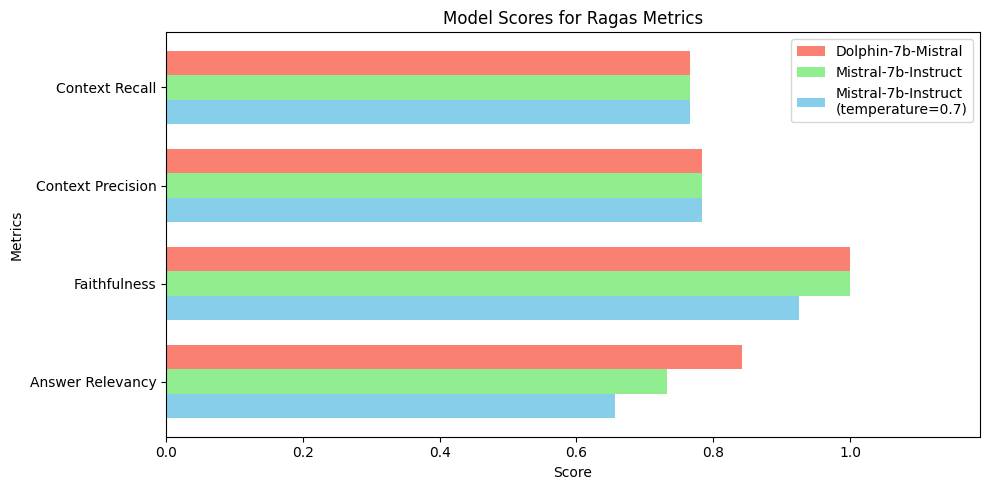

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Result dataframes
df1 = pd.DataFrame({'Answer Relevancy': [0.8426], 'Faithfulness': [1.0000], 'Context Precision': [0.7833], 'Context Recall': [0.7667]})
df2 = pd.DataFrame({'Answer Relevancy': [0.7320], 'Faithfulness': [1.0000], 'Context Precision': [0.7833], 'Context Recall': [0.7667]})
df3 = pd.DataFrame({'Answer Relevancy': [0.6569], 'Faithfulness': [0.9250], 'Context Precision': [0.7833], 'Context Recall': [0.7667]})

# # Result dataframes
# df1 = dolphin_result.to_pandas()
# df2 = mistral_result.to_pandas()
# df3 = mistral_result_temp07.to_pandas()

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Set the positions of bars on y-axis
bar_width = 0.25
index = np.arange(len(df1.columns))

# Plot bars
ax.barh(index + bar_width, df1.values[0], bar_width, label='Dolphin-7b-Mistral', color='salmon')
ax.barh(index, df2.values[0], bar_width, label='Mistral-7b-Instruct', color='lightgreen')
ax.barh(index - bar_width, df3.values[0], bar_width, label='Mistral-7b-Instruct\n(temperature=0.7)', color='skyblue')

# Adding labels and title
plt.xlabel('Score')
plt.xlim(right=1.19)
plt.ylabel('Metrics')
plt.title('Model Scores for Ragas Metrics')
plt.yticks(index, df1.columns)
plt.legend()
plt.tight_layout()
plt.show()
